# Import

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cooler
import scipy 
import seaborn as sns
from __future__ import division
import statsmodels.stats.multitest
import pybedtools

# Functions for Normalizing

In [13]:
def CTALE_norm_multiplicate(mtx,ROI_start,ROI_end,resolution,func=scipy.stats.gmean,mult=1.54):
    """mtx- matrix of individual chromosome/region +/- distance
    ROI_start - first coordinate of C-TALE region(bp)
    ROI_end - last coordinate of C-TALE region(bp)
    resolution - C-TALE map resolution(bp)
    func - function for calculating mean, can be numpy.mean,numpy.median and etc. Default: scipy.stats.gmean
    mult-coefficient of multiplication around ROI, default=1.54
    returns normalized matrix"""
    normalized=np.zeros(shape=mtx.shape)
    start_bin=int(ROI_start/resolution)
    end_bin=int(ROI_end/resolution)
    #fill main diagonal with zeros
    np.fill_diagonal(mtx,0)
    # first we multiply around region
    new_mtx=mtx*mult
    new_mtx[start_bin:end_bin,start_bin:end_bin]=mtx[start_bin:end_bin,start_bin:end_bin]
    for i in range(start_bin,end_bin):
        #left=new_mtx[i,i:]
        #up=new_mtx[:i,i]
        normalized[i,i:]=new_mtx[i,i:]/(np.sum(new_mtx[i,i:])+np.sum(new_mtx[:i,i])) #left
        normalized[:i,i]=new_mtx[:i,i]/(np.sum(new_mtx[:i,i])+np.sum(new_mtx[i,i:])) #up
    for i in range(start_bin,end_bin):
        for j in range(i+1,end_bin):
            normalized[i,j]=new_mtx[i,j]/func([np.sum(new_mtx[i,:]),np.sum(new_mtx[:,j])])
    
    i_lower = np.tril_indices(normalized.shape[0], -1) #creates symmetric matrix
    normalized[i_lower] = normalized.T[i_lower]
    return(normalized)

def CTALE_norm(mtx,ROI_start,ROI_end,resolution,func=scipy.stats.gmean):
    """Same as CTALE_norm_multiplicate function but without multiplication.
    mtx- matrix of individual chromosome/region +/- distance
    ROI_start - first coordinate of C-TALE region(bp)
    ROI_end - last coordinate of C-TALE region(bp)
    resolution - C-TALE map resolution(bp)
    func - function for calculating mean, can be numpy.mean,numpy.median and etc. Default scipy.stats.gmean
    returns normalized matrix"""
    normalized=np.zeros(shape=mtx.shape)
    start_bin=int(ROI_start/resolution)
    end_bin=int(ROI_end/resolution)
    #fill main diagonal with zeros
    np.fill_diagonal(mtx,0)
    for i in range(start_bin,end_bin):
        #left=mtx[i,i:]
        #up=mtx[:i,i]
        normalized[i,i:]=mtx[i,i:]/(np.sum(mtx[i,i:])+np.sum(mtx[:i,i])) #left
        normalized[:i,i]=mtx[:i,i]/(np.sum(mtx[:i,i])+np.sum(mtx[i,i:])) #up
    for i in range(start_bin,end_bin):
        for j in range(i+1,end_bin):
            normalized[i,j]=mtx[i,j]/func([np.sum(mtx[i,:]),np.sum(mtx[:,j])])
    i_lower = np.tril_indices(normalized.shape[0], -1) #creates symmetric matrix
    normalized[i_lower] = normalized.T[i_lower]
    return(normalized)


def multiplicate(mtx,ROI_start,ROI_end,resolution,mult=1.54):
    """mtx- matrix of individual chromosome/region +/- distance
    ROI_start - first coordinate of C-TALE region(bp)
    ROI_end - last coordinate of C-TALE region(bp)
    resolution - C-TALE map resolution(bp)
    mult-coefficient of multiplication around ROI, default=1.54
    Function perform multiplicating of matrix around ROI for selected coefficient"""
    start_bin=int(ROI_start/resolution)
    end_bin=int(ROI_end/resolution)
    #fill main diagonal with zeros
    np.fill_diagonal(mtx,0)
    # first we multiply around region
    new_mtx=mtx*mult
    new_mtx[start_bin:end_bin,start_bin:end_bin]=mtx[start_bin:end_bin,start_bin:end_bin]
    return(new_mtx)

def CTALE_norm_iterative(mtx,ROI_start,ROI_end,resolution,func=scipy.stats.gmean,mult=1.54,steps=20,tolerance=1e-5):
    """Main function that perform normalization until variance>tolerance
    mtx- matrix of individual chromosome/region +/- distance
    ROI_start - first coordinate of C-TALE region(bp)
    ROI_end - last coordinate of C-TALE region(bp)
    resolution - C-TALE map resolution(bp)
    func - function for calculating mean, can be numpy.mean,numpy.median and etc. Default: scipy.stats.gmean
    mult-coefficient of multiplication around ROI, default=1.54
    steps-number of iterations, by default=20
    tolerance-when variance<tolerance algorithm stops.
    returns normalized matrix"""
    start_bin=int(ROI_start/resolution)
    end_bin=int(ROI_end/resolution)
    out=multiplicate(mtx=mtx,ROI_start=ROI_start,ROI_end=ROI_end,resolution=resolution,mult=mult)
    for s in range(steps):
        out=CTALE_norm(out,ROI_start,ROI_end,resolution,func=func)
        var=np.var(np.sum(out[start_bin:end_bin,:],axis=1))
        print('Variance is: ',var)
        if var<tolerance:
            print('Variance < ',tolerance)
            break
    return(out)

def Save_coolfile(coolfile,mtx,output_coolfile,genome):
    """Function change raw HiC matrix of cool file to user selected (normalized) and write it to new file.
    Because function rewrite data of original cool, later you should load it with balance=False flag.
    coolfile - original HiC file
    mtx - matrix to write
    output_coolfile - name of new cool file
    genome - genome assembly id"""
    #create bins
    bins=coolfile.bins()[0:]
    #Create sparse matrix
    mtx_upper_diag = np.triu(mtx, k=0)
    smtx=scipy.sparse.csr_matrix(mtx_upper_diag)
    sc=smtx.tocoo(copy=False)
    smtx_pixels=pd.DataFrame({'bin1_id': sc.row, 'bin2_id': sc.col, 'count': sc.data})
    cooler.io.create(output_coolfile,bins,smtx_pixels,assembly=genome,dtype={'count':float})
    return('Saved')

# Tutorial

## Load Data

In [3]:
#Because we map on to ROI+/-10mb, we should subtract 17608870 from coordinates of ROI

In [4]:
#load data
AD=cooler.Cooler('DATA/Gol_1_2_AD11_20Mb_5000.cool')

In [5]:
AD.info[u'genome-assembly']

'HeLa_region_20Mb'

In [6]:
#ROI coordinates
Reg_coord=pd.read_csv('Regions/Regions_coordinates_CTALE..txt',sep='\t',header= None)
Reg_coord[1:]

,0,1
1,AD11,"chr21:27,608,870-28,888,080"


## Normalize Data

In [7]:
#load raw matrix
mtx=AD.matrix(balance=False).fetch('21')
#Perform normalization
N=CTALE_norm_iterative(mtx,27608870-17608870,28888080-17608870,5000,steps=20)

('Variance is: ', 0.007553175335196471)
('Variance is: ', 0.000962058038876745)
('Variance is: ', 0.00013626393082174907)
('Variance is: ', 2.141371343356512e-05)
('Variance is: ', 3.6440759235596203e-06)
('Variance < ', 1e-05)


## Save normalized cool

In [16]:
#Save_coolfile
Save_coolfile(AD,N,'Gol_1_2_AD11_20Mb_5000_normalized.cool',AD.info[u'genome-assembly'])

'Saved'

## Plot RAW map

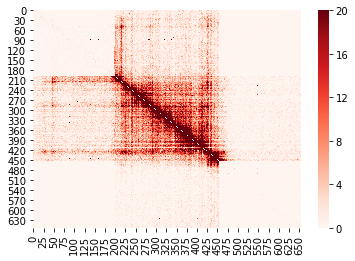

In [9]:
sns.heatmap(mtx[1800:2455,1800:2455],vmax=20,cmap='Reds')

## Plot Normalized map

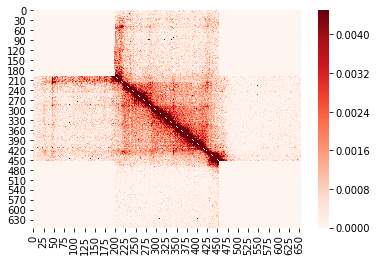

In [10]:
AD_norm=cooler.Cooler('Gol_1_2_AD11_20Mb_5000_normalized.cool')
mtx_norm=AD_norm.matrix(balance=False).fetch('21')

sns.heatmap(mtx_norm[1800:2455,1800:2455],vmax=0.0045,cmap='Reds')

In [29]:
!python2 C-TALE-normalize.py DATA/Gol_1_2_AD11_20Mb_5000.cool 21 10000000 11279210 5000 1.54 Gol_1_2_AD11_20Mb_5000_normalized_v2.cool

('Variance is: ', 0.007553175335196471)
('Variance is: ', 0.000962058038876745)
('Variance is: ', 0.00013626393082174907)
('Variance is: ', 2.141371343356512e-05)
('Variance is: ', 3.6440759235596203e-06)
('Variance < ', 1e-05)
